In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.stats import mannwhitneyu
import pandas as pd
import seaborn as sns

color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

In [2]:
#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)
######################

error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}

# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [3]:
def logistic4(x, A, B, C, D):
    """4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)
    
def get_x(y, p, dilution):
    A = p[0]
    B = p[1]
    C = p[2]
    D = p[3]
    return (C*((((A-D)/(y-D))-1)**(1/B))) *dilution


Corticosterone ELISA

In [4]:
raw_data = pd.read_csv("Cacna1h_KO_Cort.csv")


cal_conc = [0, 5, 15, 30, 60, 120]
calibration = {}

genotypes = raw_data.Genotype.unique()
raw_data["Concentration"] = 0


# Initial guess for parameters
p0 = [-1, -1, 1, 1]




# Calibrate and calculate concentrations
raw_data["Calibration"] = raw_data.apply(lambda row: leastsq(residuals, p0, args=([row.Cal0, row.Cal5, row.Cal15, row.Cal30, row.Cal60, row.Cal120], cal_conc)), axis=1)



raw_data["Concentration"] = raw_data.apply(lambda row: get_x(row.OD, row.Calibration[0], row.dilution_factor), axis=1)
raw_data.loc[raw_data.OD>2.725, "Concentration"] = 0

data = raw_data.groupby(["Animal"]).agg({'Genotype': 'first',
                                        'Concentration': 'mean',
                                        "dilution_factor": "first"}).reset_index()

C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\9199140.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\9199140.py:3: RuntimeWarning: divide by zero encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\9199140.py:3: RuntimeWarning: invalid value encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\9199140.py:3: RuntimeWarning: divide by zero encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\9199140.py:3: RuntimeWarning: invalid value encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


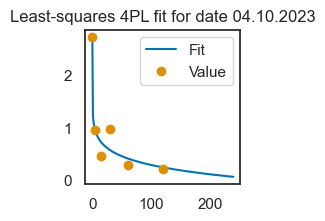

In [5]:
for date in raw_data.Date.unique():
    animal = raw_data[raw_data.Date == date].Animal.unique()[0]

    data_animal = raw_data[raw_data.Animal == animal].reset_index()
    cal_data = [data_animal.Cal0[0], data_animal.Cal5[0], data_animal.Cal15[0], data_animal.Cal30[0], 
                data_animal.Cal60[0], data_animal.Cal120[0]]

    x = cal_conc
    y_meas = cal_data

    # Initial guess for parameters
    p0 = [-.5, -1.5, 1.5, 1.5]

    # Fit equation using least squares optimization
    plsq = leastsq(residuals, p0, args=(y_meas, x))

    # Plot results
    x_hr = range(0,240,1)
    plt.figure(figsize=(2,2))
    plt.plot(x_hr,peval(x_hr,plsq[0]),x, y_meas,'o')
    plt.title(f'Least-squares 4PL fit for date {date}')
    plt.legend(['Fit', 'Value'], loc='upper right')
    #plt.semilogx()
    plt.show()
    
    calibration[animal] = plsq[0]


In [6]:
wt_values = data[data.Genotype=="WT"].Concentration.values
ko_values = data[data.Genotype=="KO"].Concentration.values

mannwhitneyu(wt_values, ko_values)

MannwhitneyuResult(statistic=141.0, pvalue=0.6234860773683975)

Text(33.0, 0.5, 'Concentration (nmol/l)')

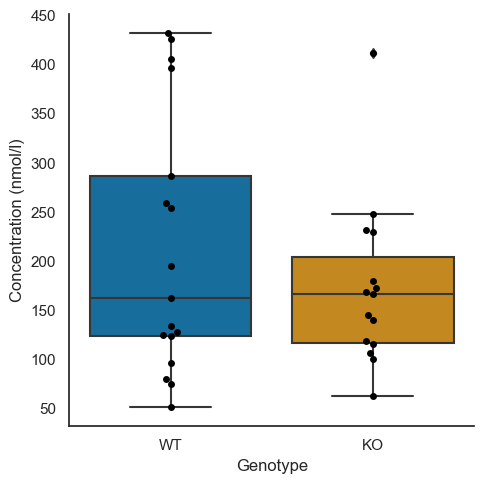

In [7]:
sns.catplot(data=data, x="Genotype", y="Concentration", kind="box")
sns.swarmplot(data=data, x="Genotype", y="Concentration", color="black")
plt.ylabel("Concentration (nmol/l)")

C:\Users\dinhha\AppData\Local\Temp\ipykernel_17568\3276128511.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(data=data, x="Genotype", y="Concentration",


Text(-19.25, 0.5, 'Concentration (nmol/l)')

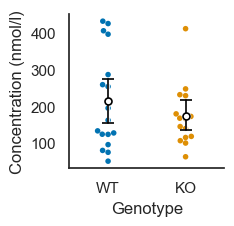

In [8]:
fig, g = plt.subplots(figsize=(2, 2))
g = sns.swarmplot(data=data, x="Genotype", y="Concentration",
                   order= ["WT", "KO"],
                 palette=[color_palette[0], color_palette[1]],
                 s=4, zorder=2, legend=False)

g = sns.lineplot(data=data, x="Genotype", y="Concentration",
                 lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)
             
    
g = sns.lineplot(data=data, x="Genotype", y="Concentration",
                 lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
plt.xlim([-0.5, 1.5])

plt.ylabel("Concentration (nmol/l)")